# Regridding for QDM-QPLAD EDA

This notebook was created to handle all regridding necessary for exploring the QDM-QPLAD approach using the forked Climate Impact Lab's forked version of `xclim`. This was due to many unsuccessful attempts to get environments straight with all the packages that would be needed for the entire effort, in particular, getting their version of `xclim` along with `xesmf` was eating up too much time, since we are really only going for a proof-of-concept with the methods here. So this notebook will simply rely on the `snap-geo` environment to perform all regridding, and the `explore_qplad.ipynb` will use the bare minimum of what is required to get the forked `xclim` package working. 

### Setup

Libs, paths, other constants:

In [1]:
from pathlib import Path
import numpy as np
import xesmf as xe
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from pyproj import CRS, Transformer, Proj
from dask.distributed import LocalCluster, Client

# we will be focusing on 4km data for now
era5_dir = Path("/beegfs/CMIP6/wrf_era5/04km")
# directory where daily 4km is stored
era5_daily_dir = Path("/beegfs/CMIP6/kmredilla/era5_4km_daily")
# downscaling project directory for writing inputs/outputs
downscaling_dir = Path("/beegfs/CMIP6/kmredilla/downscaling")

## Getting the grids straight

Here we will explore the regridding steps that need to happen to implement the full QDM-QPLAD method! In the section below we will perform the full regridding needed for each step.

The Gergel methods perform 3 separate regriddings of the ERA5 data:

1. For QDM adjustment, it's regridded to the common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. For downscaling with QPLAD, it is regridded to a 0.25° × 0.25° regular lat–long grid
3. For QPLAD adjustment factors, common grid ERA5 is resampled (nearest neighbor regridded) to the 0.25° × 0.25° regular lat–long grid


Based on that, we will explore doing each of the following here with our 4km ERA5:

1. Regrid to common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. Regrid to target 12km 3338 grid
3. Resample common grid ERA5 via NN to target 12km 3338 grid

The target grid will simply be the 4km WRF grid but reprojected to 3338.

### 1. Regrid ERA5 to common grid

We will use xESMF to regrid from the WRF grid to the regular lat-long grid. Since the WRF file already has lat / lon, we can use it as-is.

Load a comming grid CMIP6 file:

In [2]:
coarse_grid_fp = Path(
    "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/historical/Amon/tas/tas_Amon_GFDL-ESM4_historical_regrid_195001-195012.nc"
)

coarse_grid_ds = xr.open_dataset(coarse_grid_fp)

And a sample ERA5 file:

In [3]:
era5_tmp_fp = era5_dir.joinpath("2015/era5_wrf_dscale_4km_2015-12-26.nc")
era5_tmp_ds = xr.open_dataset(era5_tmp_fp)

And regrid from native ERA5 grid to common CMIP6 grid:

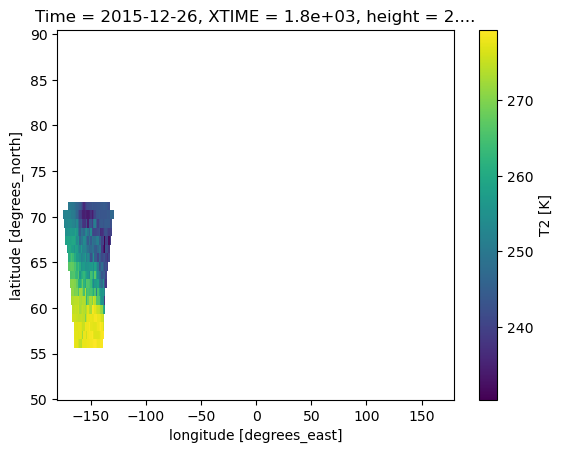

In [4]:
tmp_da = era5_tmp_ds["T2"].rename({"XLONG": "lon", "XLAT": "lat"})
era5_common_regridder = xe.Regridder(
    tmp_da, coarse_grid_ds, "bilinear", unmapped_to_nan=True
)
era5_tmp_common = era5_common_regridder(tmp_da, keep_attrs=True)
era5_tmp_common.isel(Time=0).plot()

### 2. Establish target grid 

We don't have a target grid defined at the moment, so we will make one! We can just use `rioxarray` to quickly reproject from the stereographic WRF projection to EPSG:3338. `rioxarray` is surely choosing sane defaults... :)

To do this reprojection, we will load the ancillary "geogrid" file from WRF and compute the grid coordinates by transforming the grid center lat / lon and using the grid shape and pixel size to construct the coordinates.

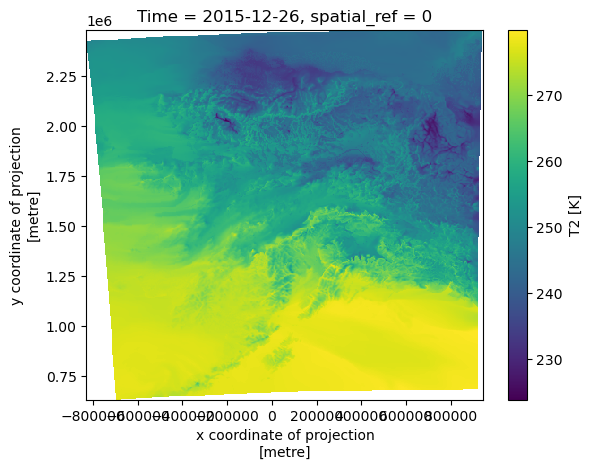

In [5]:
geo_ds = xr.open_dataset("/beegfs/CMIP6/wrf_era5/geo_em.d02.nc")

# The proj4 string for the WRF projection is:
# +proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null
# this was determined separately using the WRF-Python package
# which has spotty availability / compatability
#
# here is the code for how that was done:
# wrf_proj = PolarStereographic(
#     **{"TRUELAT1": geo_ds.attrs["TRUELAT1"], "STAND_LON": geo_ds.attrs["STAND_LON"]}
# ).proj4()
wrf_proj = "+proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null"

# WGS84 projection
wgs_proj = Proj(proj="latlong", datum="WGS84")
wgs_to_wrf_transformer = Transformer.from_proj(wgs_proj, wrf_proj)

# this is where we plug in the center longitude of the domain to get the center x, y in projected space
e, n = wgs_to_wrf_transformer.transform(
    geo_ds.attrs["CEN_LON"], geo_ds.attrs["TRUELAT1"]
)
# now compute the rest of the grid based on x/y dimension lengths and grid spacing
dx = dy = 4000
nx = era5_tmp_ds.XLONG.shape[1]
ny = era5_tmp_ds.XLONG.shape[0]
x0 = -(nx - 1) / 2.0 * dx + e
y0 = -(ny - 1) / 2.0 * dy + n
# 2d grid coordinate values
x = np.arange(nx) * dx + x0
y = np.arange(ny) * dy + y0

wrf_crs = CRS.from_proj4(wrf_proj)
era5_tmp_ds_proj = (
    era5_tmp_ds["T2"]
    .rename({"south_north": "y", "west_east": "x"})
    .assign_coords({"y": ("y", y), "x": ("x", x)})
    .drop_vars(["XLONG", "XLAT", "XTIME"])
    .rio.set_spatial_dims("x", "y")
    .to_dataset()
    .rio.write_crs(wrf_crs)
)

era5_tmp_3338 = era5_tmp_ds_proj.rio.reproject("EPSG:3338")
era5_tmp_3338.isel(Time=0).T2.plot()

### 3. Resample common grid ERA5 via NN to target 4km 3338 grid

Now that we have our common grid ERA5 as well as ERA5 on our target grid, we can use both to resample the common grid ERA5 to the target grid to get the third product, which is needed for the downscaling. 

In [6]:
# following gergel et al, this ERA5 data on the target grid is called the "fine" version.
era5_tmp_fine = era5_tmp_3338.T2

# wow copilot pretty much nailed it here
# BEGIN: Add irregular lat and lon variables
# Create a transformer from the WRF projection to WGS84
transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)

# Transform the x and y coordinates to lat and lon
xx, yy = np.meshgrid(era5_tmp_fine["x"].values, era5_tmp_fine["y"].values)
lat, lon = transformer_3338_to_4326.transform(xx, yy)

# Add the lat and lon variables to the dataset
era5_tmp_fine = era5_tmp_fine.assign_coords(
    lon=(("y", "x"), lon), lat=(("y", "x"), lat)
)

Do the regridding:

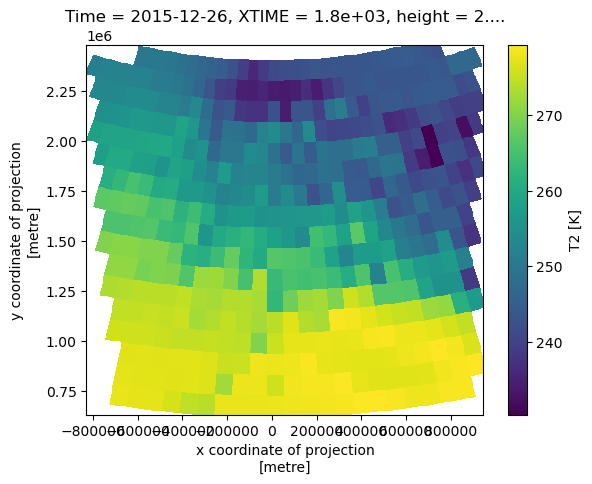

In [7]:
era5_coarse_regridder = xe.Regridder(
    era5_tmp_common, era5_tmp_fine, "nearest_s2d", unmapped_to_nan=True
)
era5_coarse = era5_coarse_regridder(era5_tmp_common, keep_attrs=True)
era5_coarse.isel(Time=0).plot()

## Regridding pipeline

This section will now implement the above regridding methods needed for each step. 

### Regridding for QDM adjustment: common grid


From the paper:

> GCM projections for each variable, GCM, experiment, pixel, year, and day at a 1◦ × 1◦ resolution are bias-adjusted using the xclim Python package QDM implementation (Logan et al., 2021). To do this, QDM models for each pixel and day of the year are trained on a rolling 31 d centered window (±15 d) of daily ERA5 and GCM historical data from 1995 to 2014. For ERA5 reference data, we include the last 15 d from 1994 and the first 15 d from 2015, such that each day group contains 620 values (20 years × 31 d). For CMIP6 historical data, since the simulation ends in 2014, we do not include the additional 15 d from 2015 or 1994 for consistency. Each trained QDM model (per pixel and day of year) has 100 equally spaced quantiles in our implementation. We used an additive adjustment for maximum and minimum temperature and a multiplicative adjustment for precipitation. Each variable was bias-adjusted separately.

So, load and regrid daily ERA5 data to the common grid.

Spin up a dask cluster:

In [8]:
# The threads_per_worker=1 seems to have really helped with open_mfdataset()
cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 28
Total threads: 28,Total memory: 125.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34053,Workers: 28
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 125.77 GiB
Comm: tcp://127.0.0.1:46261,Total threads: 1
Dashboard: http://127.0.0.1:44797/status,Memory: 4.49 GiB
Nanny: tcp://127.0.0.1:38151,


Iterate over all daily variables, regrid, and write to disk:

In [40]:
# initialize a list for storing each dataarray
era5_common_dses = []

# we need a lookup for the regridding method, as we will use different methods based on variable
interp_method_lut = {
    "t2max": "bilinear",
    "t2min": "bilinear",
    # "pr": "conservative",
    "pr": "bilinear",  # TO-DO: need to fix this in production!!
    # conservative regridding is not supported in this case because it needs corner information
    # and lat/lon vars are 2D
    # (https://xesmf.readthedocs.io/en/stable/user_api.html)
}

for var_id in ["t2max", "t2min", "pr"]:
    era5_fps = sorted(era5_daily_dir.glob(f"*{var_id}*.nc"))
    era5_ds = xr.open_mfdataset(era5_fps, parallel=True, engine="h5netcdf")

    era5_tmp_da = era5_ds.isel(time=0).load()

    interp_method = interp_method_lut[var_id]
    era5_common_regridder = xe.Regridder(
        era5_tmp_da, coarse_grid_ds, interp_method, unmapped_to_nan=True
    )
    era5_common_da = era5_common_regridder(era5_ds[var_id], keep_attrs=True)
    era5_common_dses.append(era5_common_da.to_dataset().drop_vars(["height"]))
    print(var_id, "done", end=", ")

Combine the variables into a single dataset (because it's small) and write to disk:

In [28]:
era5_common_ds = xr.merge(era5_common_dses)
era5_common_ds.to_netcdf(downscaling_dir.joinpath("era5_common.nc"))
era5_common_ds

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 7335, lat: 43, lon: 288)
Coordinates:
  * time         (time) datetime64[ns] 59kB 1994-12-17 1994-12-18 ... 2015-01-15
  * lat          (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon          (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
    spatial_ref  int64 8B 0
Data variables:
    t2max        (time, lat, lon) float32 363MB dask.array<chunksize=(15, 43, 288), meta=np.ndarray>
    t2min        (time, lat, lon) float32 363MB dask.array<chunksize=(15, 43, 288), meta=np.ndarray>
    pr           (time, lat, lon) float32 363MB dask.array<chunksize=(15, 43, 288), meta=np.ndarray>

### Regridding for QPLAD

This section will perform the remaining two regridding steps: regridding the ERA5 to the target grid to create the $ERA5_{fine}$ data, and regridding the "common" grid ERA5 to the target grid to create the $ERA5_{coarse}$ data.

#### ERA5 "fine"

Here we will regrid the ERA5 to the target resolution to create the "fine" dataset. This will be done as above, by simply reprojecting to EPSG:3338 using rioxarray. 

This should take a few minutes on a compute node:

In [29]:
era5_fine_dses = []
for var_id in ["t2max", "t2min", "pr"]:
    era5_fps = sorted(era5_daily_dir.glob(f"*{var_id}*.nc"))
    era5_ds = xr.open_mfdataset(era5_fps, parallel=True, engine="h5netcdf")

    era5_tmp_ds_proj = (
        era5_ds[var_id]
        .rename({"south_north": "y", "west_east": "x"})
        .assign_coords({"y": ("y", y), "x": ("x", x)})
        .drop_vars(["lon", "lat"])
        .rio.set_spatial_dims("x", "y")
        .to_dataset()
        .rio.write_crs(wrf_crs)
    )

    era5_tmp_fine_ds = era5_tmp_ds_proj.rio.reproject("EPSG:3338")
    era5_fine_dses.append(era5_tmp_fine_ds)
    print(var_id, "done", end=", ")

t2max done, t2min done, pr done, 

In [30]:
era5_fine_ds = xr.merge(era5_fine_dses)
era5_fine_ds.to_netcdf(downscaling_dir.joinpath("era5_fine.nc"))
era5_fine_ds

<xarray.Dataset> Size: 18GB
Dimensions:      (x: 443, y: 460, time: 7335)
Coordinates:
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
  * time         (time) datetime64[ns] 59kB 1994-12-17 1994-12-18 ... 2015-01-15
    spatial_ref  int64 8B 0
Data variables:
    t2max        (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan
    t2min        (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan
    pr           (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan

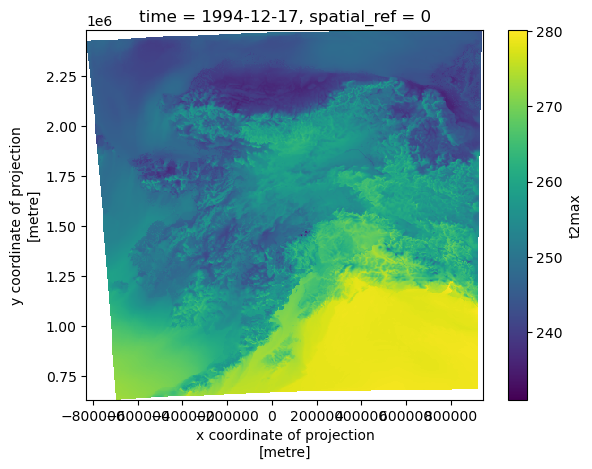

In [31]:
# sample plot
era5_fine_ds.t2max.isel(time=0).plot()

#### ERA5 "coarse"

Now we can take that common grid ERA5 dataset and make the "coarse" ERA5 by performing a nearest-neighbor resampling to the target grid. We will just reuse the regridder object created in section 3 above:

In [24]:
era5_coarse = era5_coarse_regridder(era5_common_ds, keep_attrs=True)
era5_coarse

<xarray.Dataset> Size: 18GB
Dimensions:      (time: 7335, y: 460, x: 443)
Coordinates:
  * time         (time) datetime64[ns] 59kB 1994-12-17 1994-12-18 ... 2015-01-15
    spatial_ref  int64 8B 0
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
    lon          (y, x) float64 2MB -176.7 -176.6 -176.5 ... -139.3 -139.2
    lat          (y, x) float64 2MB 70.99 71.01 71.02 71.03 ... 54.8 54.8 54.79
Data variables:
    t2max        (time, y, x) float32 6GB dask.array<chunksize=(15, 460, 443), meta=np.ndarray>
    t2min        (time, y, x) float32 6GB dask.array<chunksize=(15, 460, 443), meta=np.ndarray>
    pr           (time, y, x) float32 6GB dask.array<chunksize=(15, 460, 443), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d

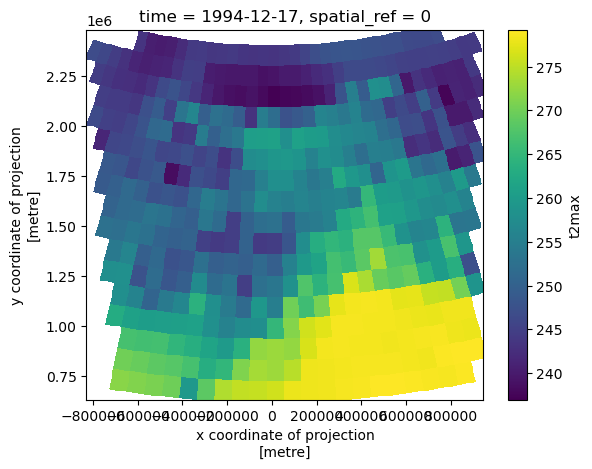

In [25]:
# sample plot
era5_coarse.t2max.isel(time=0).plot()

This will take a tiny bit longer to write as it is higher res

In [26]:
era5_coarse.to_netcdf(downscaling_dir.joinpath("era5_coarse.nc"))

#### Bias-adjusted GCM data --> target grid

Now we need to regrid the adjusted GCM to the target grid for the QPLAD downscaling.

In [52]:
year = 2000
hist_adj_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted.nc"
)
# want this to be a variable being regridded
hist_adj = xr.open_dataset(hist_adj_fp).reset_coords("sim_q", drop=False)

We will do this using the nearest neighbor method, following the Gergel et al. methods:

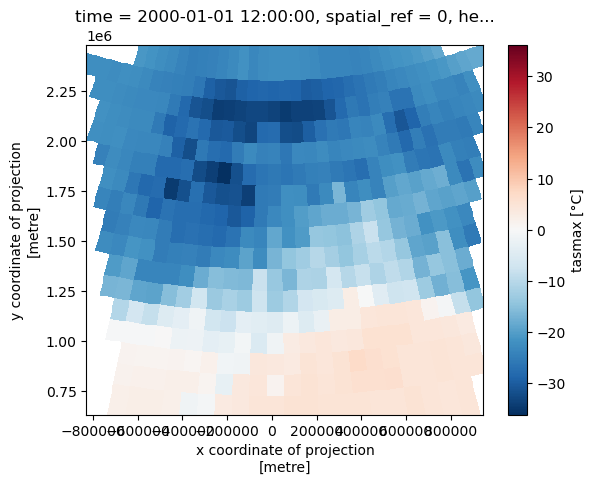

In [53]:
era5_fine_fp = downscaling_dir.joinpath("era5_fine.nc")
era5_fine = xr.open_dataset(era5_fine_fp)

# wow copilot pretty much nailed it here
# BEGIN: Add irregular lat and lon variables
# Create a transformer from the WRF projection to WGS84
transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)

# Transform the x and y coordinates to lat and lon
xx, yy = np.meshgrid(era5_fine["x"].values, era5_fine["y"].values)
lat, lon = transformer_3338_to_4326.transform(xx, yy)

# Add the lat and lon variables to the dataset
era5_fine = era5_fine.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

sim_adj_regridder = xe.Regridder(
    hist_adj, era5_fine, "nearest_s2d", unmapped_to_nan=True
)
hist_adj_fine = sim_adj_regridder(hist_adj, keep_attrs=True)
hist_adj_fine["tasmax"].isel(time=0).plot()

There we go. Now we can write this to disk for use in other exploratory efforts:

In [56]:
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine.nc"
)
hist_adj_fine_fp.unlink()
hist_adj_fine.to_netcdf(hist_adj_fine_fp)

## Target grid nested in coarse

So we have seen some issues with the QPLAD downscaling and I want to test a different target grid, or more precisely, a combination of target downscaled grid and common/coarse GCM grid such that the target grid is nested within the coarse grid. In the methods paper, a target grid is used that is exactly nested within the coarse grid such that each cell in the coarse grid contains a 4x4 grid of fine grid cells. This is not the case for the initial working configuration of the downscaling, which used an EPSG:3338 reprojection of the WRF-downscaled ERA5 as the target grid, and the common grid used for SNAP's CMIP6 ensemble.

Since our reference dataset is natively on a polar stereographic projection, which is different from the WGS84 grid of the coarse GCMs, the two most obvious options for achieving this are: 
1. create a target grid in WGS84 which is nested within the current common GCM grid. The ERA5 reference would need to be regridded to this grid for the downscaling, and the downscaled data would then need to be regridded to a production grid in 3338 from this target grid.
2. Regrid common grid GCM data to an EPSG:3338 grid that exactly contains the current working target grid. 

##### Option 1: WGS84 target grid

We can use the latitude and longitude variables in the ERA5 dataset to get an idea of the target resolution we want. 

Let's look at the histograms of differences between latitude values along the Y-axis and between longitude values along the X-axis. These should all be different because this is on a polar stereographic projection:

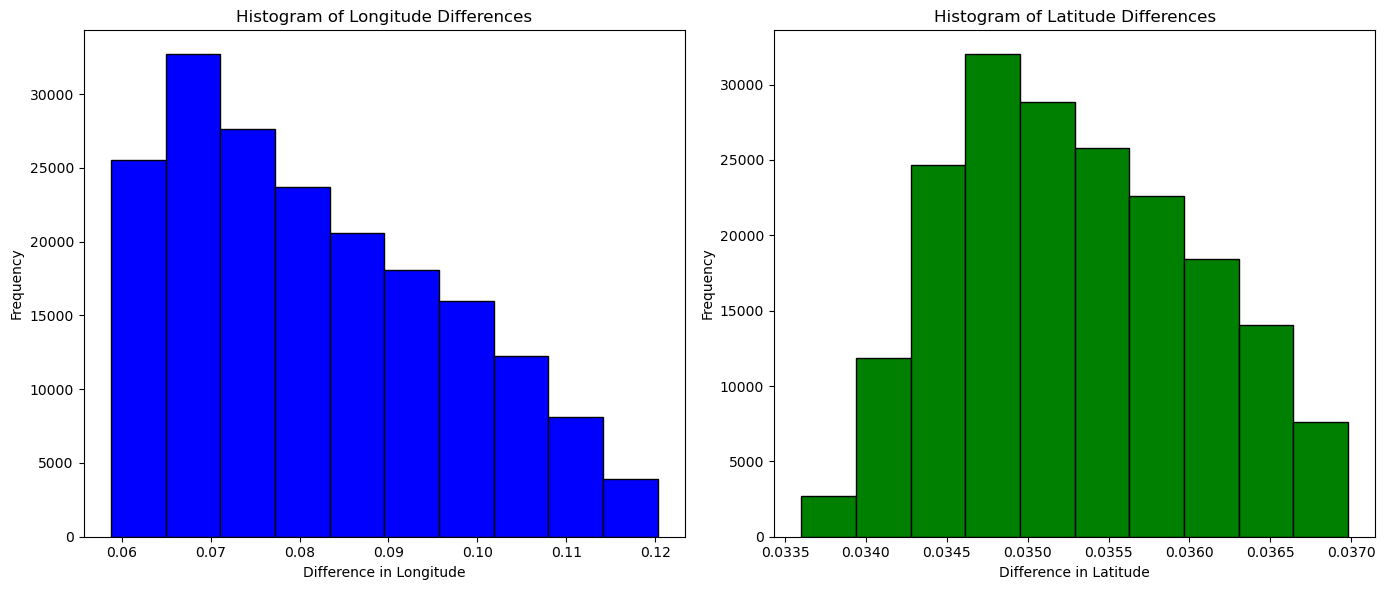

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot histogram for differences in longitude
# using axis = 1 for diffs along the x-axis
axes[0].hist(
    np.diff(era5_tmp_ds.XLONG, axis=1).flatten(), color="blue", edgecolor="black"
)
axes[0].set_title("Histogram of Longitude Differences")
axes[0].set_xlabel("Difference in Longitude")
axes[0].set_ylabel("Frequency")

# Plot histogram for differences in latitude
# using axis = 0 for diffs along the y-axis
axes[1].hist(
    np.diff(era5_tmp_ds.XLAT, axis=0).flatten(), color="green", edgecolor="black"
)
axes[1].set_title("Histogram of Latitude Differences")
axes[1].set_xlabel("Difference in Latitude")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

We can see that there is much less variation in differences in latitude values between pixels. This makes sense, because we would expect that differences in longitude between cells, taken over the x axis, would be very different between different parts of the grid, with differences in the north being smaller than within the south. 

Splitting the data into northern and southern half and showing the longitudinal differences is informative:

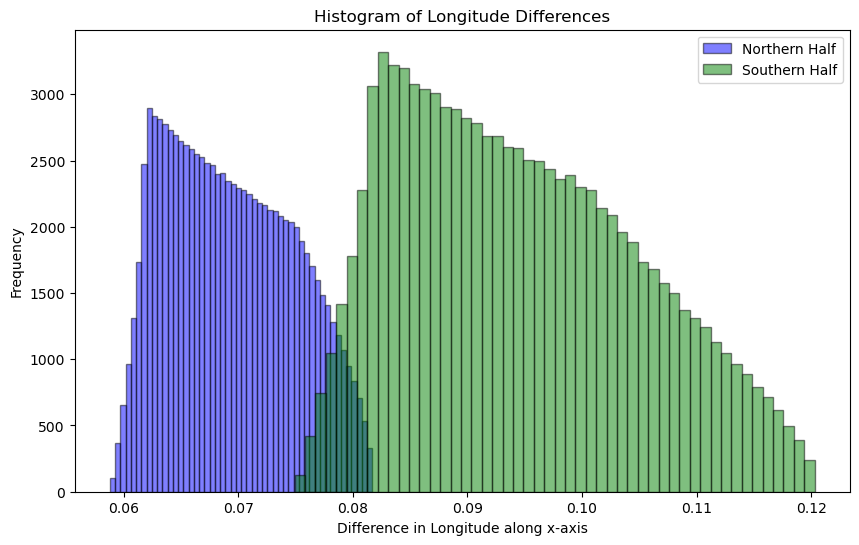

In [10]:
# Calculate the midpoint of the latitude to split the data into northern and southern halves
midpoint = era5_tmp_ds.XLAT.shape[0] // 2

# Calculate differences in longitude for northern and southern halves
lon_diffs_north = np.diff(era5_tmp_ds.XLONG[:midpoint, :], axis=1).flatten()
lon_diffs_south = np.diff(era5_tmp_ds.XLONG[midpoint:, :], axis=1).flatten()

# Plot histograms for northern and southern halves on the same plot
plt.figure(figsize=(10, 6))
plt.hist(
    lon_diffs_north,
    bins=50,
    alpha=0.5,
    label="Northern Half",
    color="blue",
    edgecolor="black",
)
plt.hist(
    lon_diffs_south,
    bins=50,
    alpha=0.5,
    label="Southern Half",
    color="green",
    edgecolor="black",
)
plt.title("Histogram of Longitude Differences")
plt.xlabel("Difference in Longitude along x-axis")
plt.ylabel("Frequency")
plt.legend()
plt.show()

So, a couple of options seem plausible for trying to set target latitude and longitude resolutions:
1. Choose the lat/lon resolution of the grid center pixel(s)
2. choose the median lat / lon resolutions from the whole grid

I'm not sure which is better. Think I will just go with the grid center resolution for now. 

Here are those resolutions:

In [11]:
print(
    "Center pixel distance in longitude",
    (era5_tmp_ds.XLONG[225, 210] - era5_tmp_ds.XLONG[224, 209]).values,
)
print(
    "Center pixel distance in latitude",
    (era5_tmp_ds.XLAT[225, 210] - era5_tmp_ds.XLAT[224, 209]).values,
)

Center pixel distance in longitude 0.08135986
Center pixel distance in latitude 0.036132812


To achieve the closest thing we can to this resolution, we can divide the latitude and longitude resolutions of the coarse GCM grid by these values:

In [12]:
lon_coarse = coarse_grid_ds.lon.values
lat_coarse = coarse_grid_ds.lat.values
print("Longitude: ", np.diff(lon_coarse)[0] / 0.08135986)
print("Latitude", np.diff(lat_coarse)[0] / 0.036132812)

Longitude:  15.363841579865058
Latitude -26.081788955793336


So we could try creating a finer grid that consists of 15 cells along the longitude axis and 26 cells along the latitude axis, and we would expect the resolution to be quite close to that of the grid center in the ERA5 grid. 

Let's create that grid with numpy!

/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


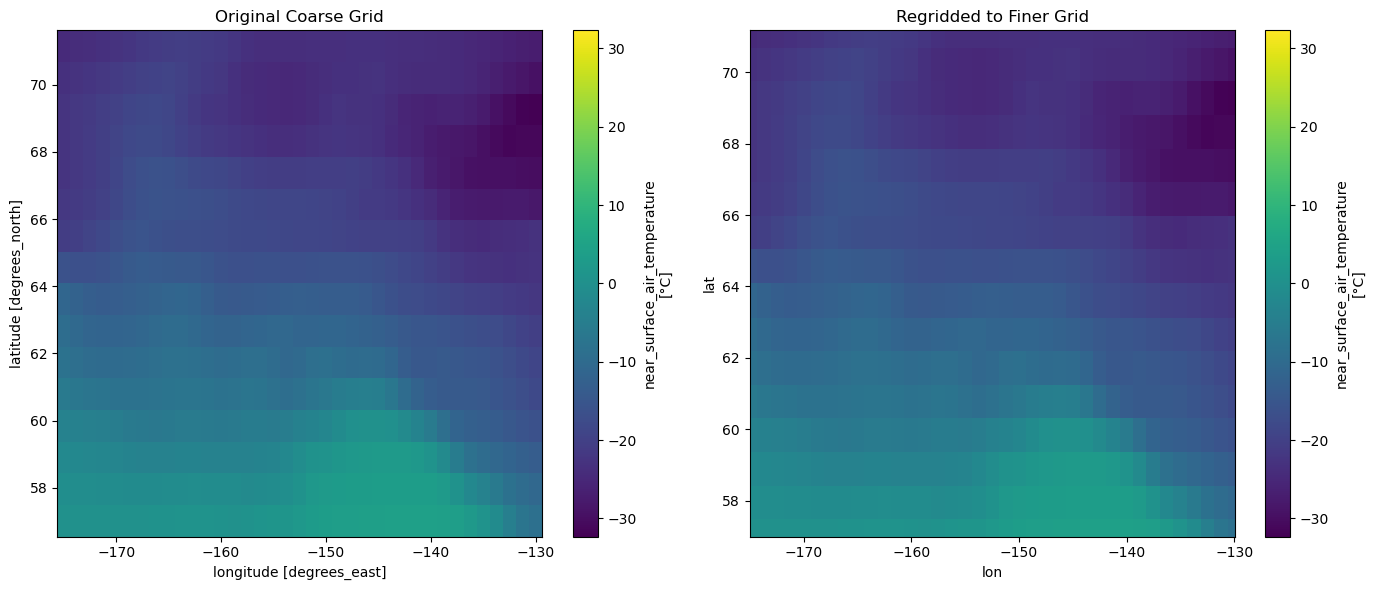

In [13]:
# first, define a selection dict for subsetting spatially to the area of data
# most of the coarse grid is nodata for the era5 data, and the target will be much higher resolution,
#  so we can focus on only regridding the extent of the era5 data
sel_di = dict(lon=slice(-175, -130), lat=slice(71.15183264, 56.07329843))
lat_coarse = coarse_grid_ds.sel(sel_di).lat.values
lon_coarse = coarse_grid_ds.sel(sel_di).lon.values

# had to do 25 instead of 26. 26 was causing weird artifacts where it appeared that the grid was not completely nested
lat_fine = np.linspace(lat_coarse.min(), lat_coarse.max(), len(lat_coarse) * 25)
lon_fine = np.linspace(lon_coarse.min(), lon_coarse.max(), len(lon_coarse) * 15)

# Create a meshgrid for the finer grid
lon_fine_grid, lat_fine_grid = np.meshgrid(lon_fine, lat_fine)

# Create a new xarray dataset for the finer grid
wgs84_target_ds = xr.Dataset({"lat": (["lat"], lat_fine), "lon": (["lon"], lon_fine)})

# Regrid era5_tmp_common to the finer grid
wgs84_target_regridder = xe.Regridder(
    coarse_grid_ds["tas"], wgs84_target_ds, "nearest_s2d", unmapped_to_nan=True
)
gcm_wgs84_fine = wgs84_target_regridder(coarse_grid_ds["tas"], keep_attrs=True)

# Plot the original coarse grid data and the regridded data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the original coarse grid data
coarse_grid_ds["tas"].sel(sel_di).transpose("time", "lat", "lon").isel(time=0).plot(
    ax=axes[0], cmap="viridis"
)
axes[0].set_title("Original Coarse Grid")

# Plot the regridded data
gcm_wgs84_fine.isel(time=0).plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Regridded to Finer Grid")

plt.tight_layout()
plt.show()

This is good! The above plots look the exact same because the target grid is exactly nested and the data was resampled via nearest neighbor. You can see that it is much higher resolution in both dimensions now:

In [14]:
print(gcm_wgs84_fine.lat, "\n")
print(gcm_wgs84_fine.lon)

<xarray.DataArray 'lat' (lat: 400)> Size: 3kB
array([57.015707, 57.051136, 57.086565, ..., 71.080975, 71.116404, 71.151832])
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 3kB 57.02 57.05 57.09 57.12 ... 71.08 71.12 71.15 

<xarray.DataArray 'lon' (lon: 555)> Size: 4kB
array([-175.      , -174.918773, -174.837545, ..., -130.162455, -130.081227,
       -130.      ])
Coordinates:
    height   float64 8B ...
  * lon      (lon) float64 4kB -175.0 -174.9 -174.8 ... -130.2 -130.1 -130.0


one degree of latitude is ~111 km, so with our new latitude resolution of 0.0354288, this should be a distance of ~3.93km.

We can compute what longitude distances this corresponds to at different longitudes:

In [15]:
# the following is a copilot function to convert degrees longitude to distance in kilometers based on latitude
from pyproj import Geod


def lon_to_km(lon_diff, lat):
    """
    Convert degrees longitude to distance in kilometers based on latitude.

    Parameters:
    lon_diff (float): Difference in degrees longitude.
    lat (float): Latitude in degrees.

    Returns:
    float: Distance in kilometers.
    """
    geod = Geod(ellps="WGS84")
    # Calculate the distance between two points with the same latitude but different longitudes
    _, _, distance = geod.inv(lon_diff, lat, 0, lat)
    return distance / 1000  # Convert meters to kilometers


lon_res = np.diff(gcm_wgs84_fine.lon)[0]
print("Longitude resoltuion:", lon_res)
for lat in [50, 60, 70]:
    distance_km = lon_to_km(lon_res, lat)
    print(f"Cell width at latitude {lat}°: {distance_km:.2f} km")

Longitude resoltuion: 0.08122743682309874
Cell width at latitude 50°: 5.82 km
Cell width at latitude 60°: 4.53 km
Cell width at latitude 70°: 3.10 km


Okay, to recap: this is the GCM data that has been regridded to a finer, nested grid via nearest neighbor resampling giving the exact same appearance when plotted. We will try this grid as our new target grid, which we will regrid all ERA5 data to. The new nested grid was chosen based on the "resolution" of the center of the irregular WGS84 grid included with the downscaled ERA5 data. This "fine" target grid in WGS84 has a resolution of approximately 4km, with cells being smaller than that in the northern half and larger than that in the southern half. 



#### Nested WGS84 grid ERA5 fine 

Now we need to reproject all of the ERA5 data from the WRF polar stereographic grid to the new target grid and save:

In [36]:
# we need a lookup for the regridding method, as we will use different methods based on variable
interp_method_lut = {
    "t2max": "bilinear",
    "t2min": "bilinear",
    # "pr": "conservative",
    "pr": "bilinear",  # TO-DO: need to fix this in production!!
    # conservative regridding is not supported in this case because it needs corner information
    # and lat/lon vars are 2D
    # (https://xesmf.readthedocs.io/en/stable/user_api.html)
}

wgs84_fine_dir = downscaling_dir.joinpath("era5_fine_wgs84")
wgs84_fine_dir.mkdir(exist_ok=True)

# initialize regridder from WRF to WGS84 using sample ERA5 file
era5_tmp_ds = xr.open_dataset(list(era5_daily_dir.glob(f"*{var_id}*.nc"))[0])
wgs84_target_regridder = xe.Regridder(
    era5_tmp_ds[var_id], wgs84_target_ds, interp_method, unmapped_to_nan=True
)

for var_id in ["t2max", "t2min", "pr"]:
    era5_fps = sorted(era5_daily_dir.glob(f"*{var_id}*.nc"))
    interp_method = interp_method_lut[var_id]

    for fp in era5_fps:
        # each file is a year
        era5_ds = xr.open_dataset(fp, engine="h5netcdf")
        era5_wgs84_fine = wgs84_target_regridder(era5_ds[var_id], keep_attrs=True)
        era5_wgs84_fine.to_netcdf(
            wgs84_fine_dir.joinpath(fp.name.replace(".nc", "_wgs84.nc"))
        )

    print(var_id, "done", end=", ")

t2max done, t2min done, pr done, 

Sample plots of regridding:

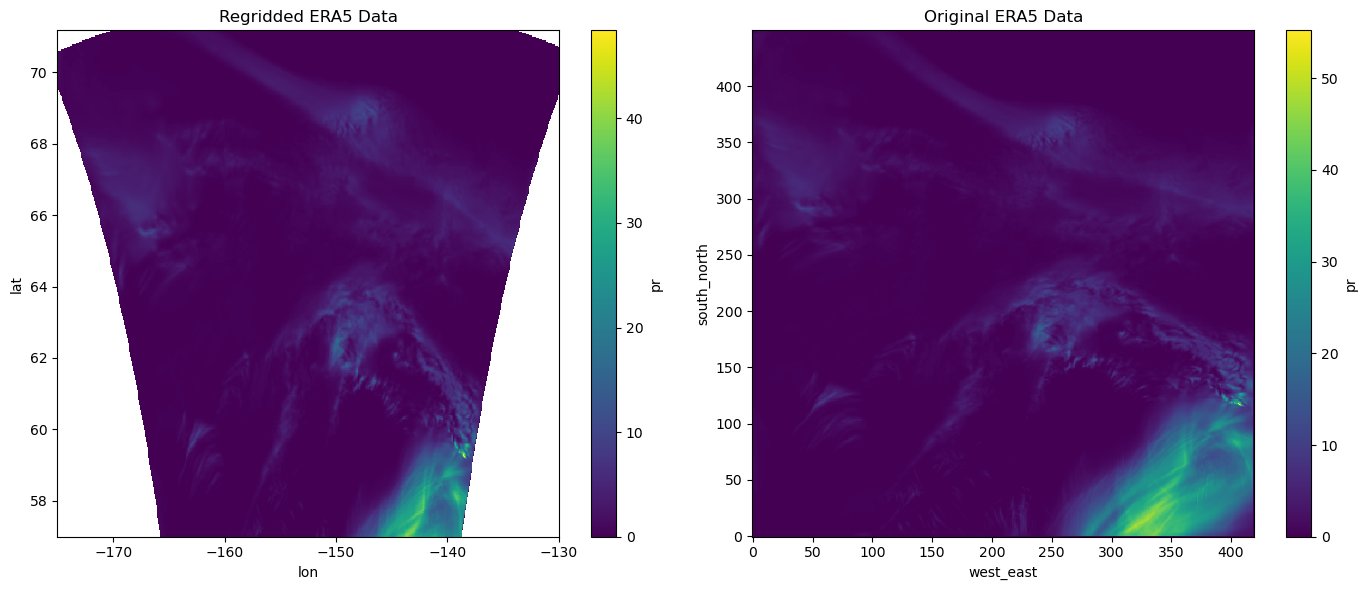

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the regridded ERA5 data
era5_wgs84_fine.isel(time=0).plot(ax=axes[0], cmap="viridis")
axes[0].set_title("Regridded ERA5 Data")

# Plot the original ERA5 data
era5_ds["pr"].isel(time=0).plot(ax=axes[1], cmap="viridis")
axes[1].set_title("Original ERA5 Data")

plt.tight_layout()
plt.show()

#### ERA5 "coarse" (WGS84 target)

Now we can take that common grid ERA5 dataset and make the "coarse" ERA5 needed for QPLAD downscaling by performing a nearest-neighbor resampling to the new target grid in WGS84. We will create a regridding object from the :

In [52]:
# open if needed
era5_common_ds = xr.open_dataset(downscaling_dir.joinpath("era5_common.nc"))
era5_coarse_regridder = xe.Regridder(
    era5_common_ds.sel(sel_di), wgs84_target_ds, "nearest_s2d", unmapped_to_nan=True
)

In [53]:
era5_coarse = era5_coarse_regridder(era5_common_ds.sel(sel_di), keep_attrs=True)
era5_coarse

<xarray.Dataset> Size: 20GB
Dimensions:      (time: 7335, lat: 400, lon: 555)
Coordinates:
  * time         (time) datetime64[ns] 59kB 1994-12-17 1994-12-18 ... 2015-01-15
    spatial_ref  int64 8B ...
  * lat          (lat) float64 3kB 57.02 57.05 57.09 57.12 ... 71.08 71.12 71.15
  * lon          (lon) float64 4kB -175.0 -174.9 -174.8 ... -130.2 -130.1 -130.0
Data variables:
    t2max        (time, lat, lon) float32 7GB nan nan nan nan ... nan nan nan
    t2min        (time, lat, lon) float32 7GB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float32 7GB nan nan nan nan ... nan nan nan
Attributes:
    regrid_method:  nearest_s2d

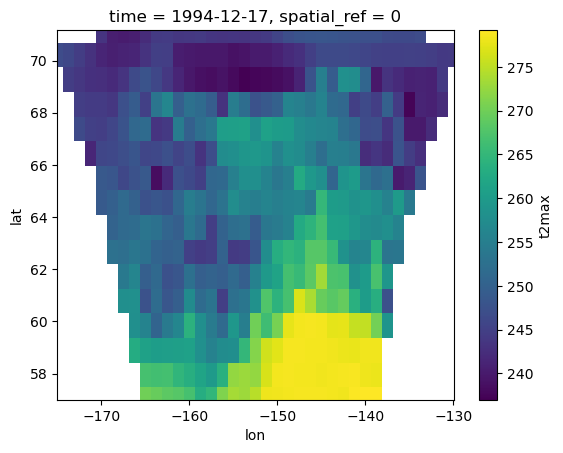

In [54]:
# sample plot
era5_coarse.t2max.isel(time=0).plot()

This will take a tiny bit longer to write as it is higher res

In [55]:
era5_coarse.to_netcdf(downscaling_dir.joinpath("era5_coarse_wgs84.nc"))

#### Bias-adjusted GCM data --> target WGS84 grid

Now we need to regrid the adjusted GCM to the target grid for the QPLAD downscaling.
We will just do a single year here for testing.

In [56]:
year = 2000
hist_adj_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted.nc"
)
# want this to be a variable being regridded
hist_adj = xr.open_dataset(hist_adj_fp).reset_coords("sim_q", drop=False)

We will do this using the nearest neighbor method, following the Gergel et al. methods:

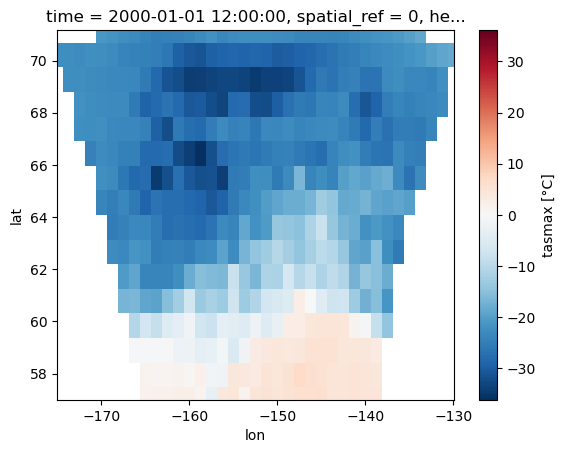

In [57]:
sim_adj_regridder = xe.Regridder(
    hist_adj, wgs84_target_ds, "nearest_s2d", unmapped_to_nan=True
)
hist_adj_fine = sim_adj_regridder(hist_adj, keep_attrs=True)
hist_adj_fine["tasmax"].isel(time=0).plot()

There we go. Now we can write this to disk for use in other exploratory efforts:

In [58]:
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine_wgs84.nc"
)
hist_adj_fine.to_netcdf(hist_adj_fine_fp)